In [379]:
%matplotlib inline

import pydicom
import pandas as pd

import numpy as np

from utils import rle2mask
from pprint import pprint

from tqdm import tqdm_notebook

import concurrent.futures

import glob

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, Flatten, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers.merge import Concatenate
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf


In [185]:
fnames = glob.glob("data/dicom-images-train/*/*/*.dcm")
data = []
def get_info(fname):
    ds = pydicom.read_file(fname)
#     # convert RawDataElement to DataElement to access by attr (stupid on demand stuff depends on iteration)
#     for _ in ds: pass
#     d = { v.name:v.value for v in ds.values() if v.name not in ["Pixel Data"] }
    return dict(
        age=int(getattr(ds,"PatientAge")),
        gender=str(getattr(ds,"PatientSex")),
        viewpos=str(getattr(ds,"ViewPosition")),
        pixspacing=round(getattr(ds,"PixelSpacing")[0],3),
        fname=fname,
    )

executor = concurrent.futures.ProcessPoolExecutor(4)
futures = [executor.submit(get_info,fname) for fname in fnames]
data = []
for future in tqdm_notebook(concurrent.futures.as_completed(futures),total=len(futures)):
    data.append(future.result())
dfmeta = pd.DataFrame(data)

Process Process-5:
Process Process-7:
Process Process-8:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multipr

In [186]:
# Better dtypes
dfmeta[["gender","viewpos"]] = dfmeta[["gender","viewpos"]].astype("category")
dfmeta["age"] = dfmeta["age"].astype(int)
# To cross reference with the rles CSV file
dfmeta["ImageId"] = dfmeta["fname"].str.rsplit("/",1).str[-1].str.rsplit(".",1).str[0]

# Read rle csv file, clean it up. Empty strings will mean not sick
rles = pd.read_csv("data/train-rle.csv").rename(columns=lambda x:x.strip())
rles["EncodedPixels"] = rles["EncodedPixels"].str.replace("-1","").str.strip()

In [187]:
# There can be multiple annotations (blobs) per image in the rle csv file
# So multiple rows per actual image
# Group by the ImageId, and join the EncodedPixels strings with ","
x = rles.groupby("ImageId")["EncodedPixels"].apply(",".join)
# Then put this information into the dfmeta dataframe, splitting by "," 
# to get back a list of the EncodedPixels strings, taking advantage of a
# temporary common index ImageId
dfmeta = dfmeta.set_index("ImageId").assign(EncodedPixels=x.str.split(",")).reset_index(drop=True)
# There's ~37 entries that aren't in the csv file D:
dfmeta = dfmeta.dropna().reset_index(drop=True)

# Count up number of annotations. If the first (and only one) is null ([""]), then it's 0
dfmeta["num"] = dfmeta["EncodedPixels"].map(lambda x:(len(x[0])>0)*len(x))
# Sick if there's at least one annotation
dfmeta["sick"] = dfmeta["num"] > 0

In [188]:
dfmeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10675 entries, 0 to 10674
Data columns (total 8 columns):
age              10675 non-null int64
fname            10675 non-null object
gender           10675 non-null category
pixspacing       10675 non-null float64
viewpos          10675 non-null category
EncodedPixels    10675 non-null object
num              10675 non-null int64
sick             10675 non-null bool
dtypes: bool(1), category(2), float64(1), int64(2), object(2)
memory usage: 448.5+ KB


In [189]:
def clean(ax):
    ax.set_frame_on(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

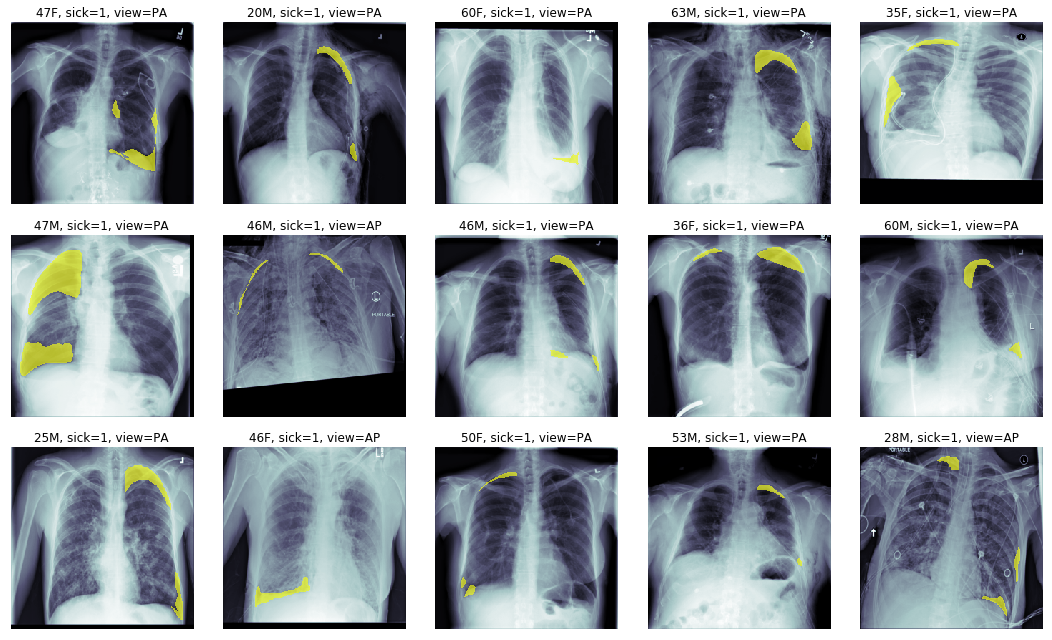

In [268]:
entries = dfmeta[dfmeta["num"]>0].iloc[:15]
do_downscale = True

fig,axs = plt.subplots(3,5,figsize=(15,9),sharex=True,sharey=True)

def downscale(x,ismask=False,factor=4):
#     return x
    if not ismask:
        return resize(x,(x.shape[0]/factor, x.shape[1]/factor),anti_aliasing=True)
    else:
        x = downscale_local_mean(x,(factor,factor))
        x[x >= 128.] = 255.
        x[x < 128.] = 0.
        return x
        

for i,ax in zip(range(len(entries)),axs.flat):
    entry = entries.iloc[i]
    fname = entry.fname
    ds = pydicom.read_file(fname)
    img = ds.pixel_array
    # EncodedPixels is a list of the blobs, so we convert each to numpy
    ep = map(rle2mask,entry.EncodedPixels)
    # Then we basically take the logical OR over all the blobs and multiply back in the 255
    # Note the transpose to flip the matrix (not sure why)
    ep = reduce(lambda x,y: ((x+y)>0), ep).T*255
    
    if do_downscale:
        img = downscale(img,ismask=False,factor=4)
        ep = downscale(ep,ismask=True,factor=4)
    
    ax.imshow(img, cmap=plt.cm.bone)
    # Mask the array to just overlay the blobs
    mask = np.ma.masked_where(ep<254, ep)
    ax.imshow(mask, alpha=0.7, cmap="plasma_r")
    ax.set_title("{}{}, sick={}, view={}".format(entry.age,entry.gender,int(entry.sick),entry.viewpos))
map(clean,axs.flat);
fig.set_tight_layout(True)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
dfmeta.groupby(["viewpos","gender","pixspacing"])["sick"].mean().plot(kind="barh")

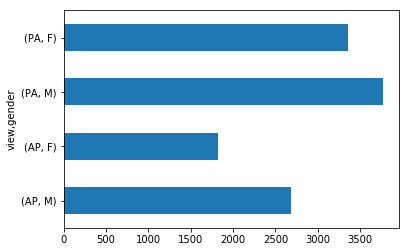

In [39]:
dfmeta.groupby("view")["gender"].value_counts().plot(kind="barh")
# dfmeta.groupby(["gender","view"]).value_counts().plot()

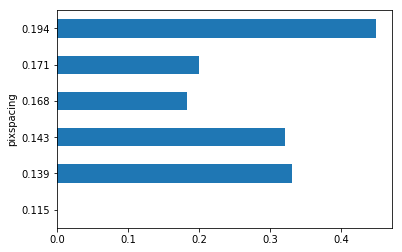

In [46]:
# dfmeta.groupby("sick")["gender"].value_counts().plot(kind="barh")
dfmeta.groupby("pixspacing")["sick"].mean().plot(kind="barh")
# dfmeta.groupby("pixspacing")["sick"].value_counts().plot(kind="barh")
# dfmeta.pixspacing.value_counts()

In [45]:
dfmeta[dfmeta.age>100]

,age,fname,gender,pixspacing,view,ImageId,EncodedPixels,sick
8327,148,data/dicom-images-train/1.2.276.0.7230010.3.1....,M,0.143,PA,1.2.276.0.7230010.3.1.4.8323329.4830.151787518...,-1,0.0
11366,413,data/dicom-images-train/1.2.276.0.7230010.3.1....,F,0.139,AP,1.2.276.0.7230010.3.1.4.8323329.11106.15178752...,-1,0.0


sick
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

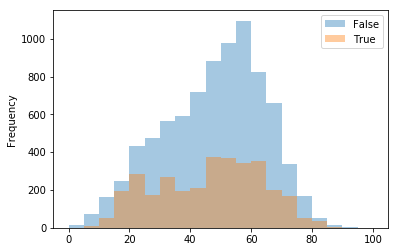

In [286]:
# dfmeta.groupby("gender")["age"].plot.hist(bins=np.linspace(0,100,20),alpha=0.4,density=True,legend=True)
# dfmeta.groupby("view")["age"].plot.hist(bins=np.linspace(0,100,20),alpha=0.4,density=True,legend=True)
dfmeta.groupby("sick")["age"].plot.hist(bins=np.linspace(0,100,21),alpha=0.4,legend=True)
# print dfmeta.age[dfmeta.age<9]

In [5]:
fnames = glob.glob("data/dicom-images-train/*/*/*.dcm")
data = []
def get_info(fname):
    ds = pydicom.read_file(fname)
    # convert RawDataElement to DataElement to access by attr (stupid on demand stuff depends on iteration)
    for _ in ds: pass
    return { v.name:v.value for v in ds.values() if v.name not in ["Pixel Data"] }
# print get_info(fnames[0])

# data = [get_info(fname) for fname in tqdm_notebook(fnames[:100])]
data = [get_info(fname) for fname in tqdm_notebook(fnames)]
# executor = concurrent.futures.ProcessPoolExecutor(4)
# futures = [executor.submit(get_info,fname) for fname in fnames]
# data = []
# for future in tqdm_notebook(concurrent.futures.as_completed(futures),total=len(futures)):
#     data.append(future.result())
# dfmeta = pd.DataFrame(data)

In [6]:
dfmeta = pd.DataFrame(data)

In [11]:
for k in dfmeta.columns:
    vc = dfmeta[k].value_counts()
    if (len(vc) == len(dfmeta)): continue
    if (len(vc) == 1): continue
    print "------- {}, {} ------".format(k, len(vc))
    print vc

------- Patient's Age, 93 ------
58     323
57     275
51     266
55     265
49     255
56     255
60     254
52     254
54     247
53     243
46     237
59     235
64     234
47     231
65     225
50     222
63     219
45     215
62     210
48     208
66     204
44     197
40     189
43     183
61     182
24     178
35     177
30     169
39     167
42     164
      ... 
13      47
75      47
14      43
78      42
10      41
80      28
9       26
12      24
81      22
8       20
83      17
79      15
5       12
6       11
7       10
82       8
85       7
4        6
87       5
2        5
3        4
86       3
84       2
88       2
89       1
90       1
413      1
94       1
1        1
148      1
Name: Patient's Age, Length: 93, dtype: int64
------- Patient's Sex, 2 ------
M    5903
F    4809
Name: Patient's Sex, dtype: int64
------- Pixel Spacing, 6165 ------
[0.14300000000000002, 0.14300000000000002]    14
[0.14300000000000002, 0.14300000000000002]    14
[0.14300000000000002, 0.1430000

In [18]:
dfmeta["Pixel Spacing"].map(lambda x: round(list(x)[0],3)).value_counts()

0.14    5946
0.17    4021
0.19     743
0.12       2
Name: Pixel Spacing, dtype: int64

In [15]:
dfmeta["Pixel Spacing"].map(lambda x: round(list(x)[1],3)).value_counts()

0.143    3970
0.168    3230
0.139    1976
0.171     791
0.194     743
0.115       2
Name: Pixel Spacing, dtype: int64

In [22]:
round(pydicom.read_file(fnames[0]).PixelSpacing[0],3)

0.168

In [48]:
dfmeta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11619 entries, 0 to 11618
Data columns (total 8 columns):
age              11619 non-null int64
fname            11619 non-null object
gender           11619 non-null category
pixspacing       11619 non-null float64
view             11619 non-null category
ImageId          11619 non-null object
EncodedPixels    11582 non-null object
sick             11582 non-null float64
dtypes: category(2), float64(2), int64(1), object(3)
memory usage: 658.3+ KB


In [194]:
entry = dfmeta.iloc[0]
ds = pydicom.read_file(fname)
img = ds.pixel_array
print img
print entry.sick

[[  0   3  14 ... 115 115 108]
 [  2   7  20 ... 201 201 193]
 [  0   5  19 ... 192 191 184]
 ...
 [  0  23  68 ...  21  21  21]
 [  2  21  65 ...  15  15  15]
 [  1   0   7 ...   0   0   0]]
False


In [388]:
im_height = 1024
im_width = 1024
im_chan = 1
# Get and resize train images and masks
# X_train = np.zeros((10, im_height, im_width, im_chan), dtype=np.uint8)
X_train = []
E_train = []
Y_train = []

for i in tqdm_notebook(range(3000)):
    entry = dfmeta.iloc[i]
    fname = entry.fname
    img = pydicom.read_file(fname).pixel_array
#     img = downscale(img,ismask=False,factor=4)
    img = downscale(img,ismask=False,factor=4)
#     print img.shape
    img = (np.expand_dims(img,axis=2)/255.)
    X_train.append(img)
    Y_train.append(entry.sick)
    E_train.append([
        entry.age/100.,int(entry.gender == "M"),int(entry.viewpos == "PA"),
    ])

X_train = np.stack(X_train).astype(np.float16)
E_train = np.stack(E_train).astype(np.float16)
Y_train = 1.0*np.array(Y_train)

print X_train.shape
print X_train.dtype
print E_train.shape
print E_train.dtype
print Y_train.shape
print Y_train.dtype

print "{:.1f}MB".format(X_train.nbytes/1e6)
print "{:.1f}MB".format(E_train.nbytes/1e6)
print "{:.1f}MB".format(Y_train.nbytes/1e6)

#     X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
#     if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
#         Y_train[n] = np.expand_dims(rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T, axis=2)
#     else:
#         Y_train[n] = np.zeros((1024, 1024, 1))


(3000, 256, 256, 1)
float16
(3000, 3)
float16
(3000,)
float64
393.2MB
0.0MB
0.0MB


In [389]:
# inputs = Input((im_height, im_width, im_chan))
inputs = Input((im_height//4, im_width//4, im_chan))

aux_inputs = Input((E_train.shape[-1],))

c1 = Conv2D(16, (5, 5), activation=None, padding='same') (inputs)
c1 = LeakyReLU(0.1)(c1)
p1 = MaxPool2D((3, 3)) (c1)

c2 = Conv2D(16, (4, 4), activation=None, padding='same') (p1)
c2 = LeakyReLU(0.1)(c2)
p2 = MaxPool2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation=None, padding='same') (p2)
c3 = LeakyReLU(0.1)(c3)
p3 = MaxPool2D((2, 2)) (c3)

c4 = Conv2D(32, (3, 3), activation=None, padding='same') (p3)
c4 = LeakyReLU(0.1)(c4)
p4 = MaxPool2D(pool_size=(3, 3)) (c4)

flat = Flatten()(p4)


# flat = Concatenate()([flat,aux_inputs])

d1 = Dense(128,activation="relu")(flat)
d1 = Dropout(0.2)(d1)
d2 = Dense(32,activation="relu")(d1)
d2 = Dropout(0.2)(d2)
d3 = Dense(32,activation="relu")(d2)
d3 = Dropout(0.2)(d3)
outputs = Dense(1,activation="sigmoid")(d3)

# def auroc(y_true, y_pred):
#     return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


model = Model(inputs=[inputs], outputs=[outputs])
# model = Model(inputs=[inputs,aux_inputs], outputs=[outputs])
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=["accuracy"])
# model.compile(optimizer='adam', loss="mse",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 256, 256, 16)      416       
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 85, 85, 16)        4112      
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 85, 85, 16)        0         
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 42, 42, 16)        0         
__________

In [390]:
history = model.fit(X_train, Y_train, validation_split=0.25, batch_size=16, epochs=5,shuffle=True)
# history = model.fit([X_train,E_train], Y_train, validation_split=.33, batch_size=16, epochs=3,shuffle=True)

Train on 2250 samples, validate on 750 samples
Epoch 1/5
2250/2250 [==============================] - 99s 44ms/step - loss: 0.5611 - acc: 0.7716 - val_loss: 0.5674 - val_acc: 0.7640
Epoch 2/5
2250/2250 [==============================] - 97s 43ms/step - loss: 0.5477 - acc: 0.7720 - val_loss: 0.5464 - val_acc: 0.7640
Epoch 3/5
 368/2250 [===>..........................] - ETA: 1:14 - loss: 0.5340 - acc: 0.7880

KeyboardInterrupt: 

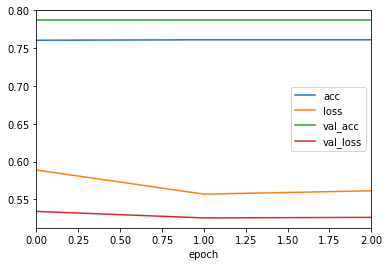

In [391]:
pd.DataFrame(history.history).reset_index().rename({"index":"epoch"},axis=1).set_index("epoch").plot()

In [394]:
preds = model.predict(X_train[-800:],verbose=1)
fpr, tpr, thresh = roc_curve(Y_train[-800:], preds)

800/800 [==============================] - 10s 13ms/step


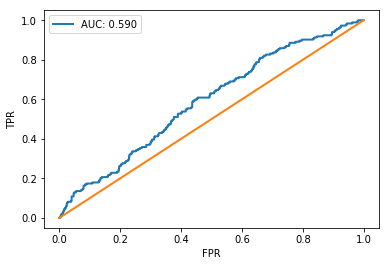

In [395]:
auc = np.trapz(tpr,x=fpr)

fig,ax = plt.subplots()
ax.plot(fpr,tpr,lw=2,label="AUC: {:.3f}".format(auc))
ax.plot([0,1],[0,1],lw=2)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend()


In [396]:
E_train

array([[0.34, 0.  , 1.  ],
       [0.2 , 0.  , 1.  ],
       [0.61, 0.  , 1.  ],
       ...,
       [0.28, 1.  , 0.  ],
       [0.31, 1.  , 1.  ],
       [0.37, 0.  , 1.  ]], dtype=float16)

In [397]:
inputs = Input((im_height//4, im_width//4, im_chan))

c1 = Conv2D(16, (5, 5), activation=None, padding='same') (inputs)
c1 = LeakyReLU(0.1)(c1)
p1 = MaxPool2D((3, 3)) (c1)

c2 = Conv2D(16, (4, 4), activation=None, padding='same') (p1)
c2 = LeakyReLU(0.1)(c2)
p2 = MaxPool2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation=None, padding='same') (p2)
c3 = LeakyReLU(0.1)(c3)
p3 = MaxPool2D((2, 2)) (c3)

c4 = Conv2D(32, (3, 3), activation=None, padding='same') (p3)
c4 = LeakyReLU(0.1)(c4)
p4 = MaxPool2D(pool_size=(3, 3)) (c4)

flat = Flatten()(p4)

d1 = Dense(128,activation="relu")(flat)
d1 = Dropout(0.2)(d1)
d2 = Dense(32,activation="relu")(d1)
d2 = Dropout(0.2)(d2)
d3 = Dense(32,activation="relu")(d2)
d3 = Dropout(0.2)(d3)
outputs = Dense(1,activation="linear")(d3)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss="mse",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 256, 256, 16)      416       
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 85, 85, 16)        4112      
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 85, 85, 16)        0         
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 42, 42, 16)        0         
__________

In [ ]:
ages = E_train[:,0]*100
history = model.fit(X_train, ages, validation_split=0.25, batch_size=16, epochs=5,shuffle=True)

Train on 2250 samples, validate on 750 samples
Epoch 1/5
2250/2250 [==============================] - 100s 44ms/step - loss: 784.2341 - acc: 0.0102 - val_loss: 355.2388 - val_acc: 0.0173
Epoch 2/5
2250/2250 [==============================] - 98s 44ms/step - loss: 399.3801 - acc: 0.0196 - val_loss: 356.6883 - val_acc: 0.0187
Epoch 3/5
1184/2250 [==============>...............] - ETA: 42s - loss: 389.3000 - acc: 0.0084